In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

repo_dir = os.getcwd() + '/repo'
tft_dir = os.path.join(repo_dir, 'tft')
os.chdir(tft_dir)

import warnings  
warnings.filterwarnings('ignore')

In [4]:
!ls

data_formatters			       README.md
expt_settings			       repo
libs				       requirements.txt
output_folder			       run.sh
outputs				       script_download_data.py
outputs_pm2.5			       script_hyperparam_opt.py
outputs_stock			       script_train_fixed_params.py
PRSA_data_2010.1.1-2014.12.31 (1).csv  stock.csv
PRSA_data_2010.1.1-2014.12.31.csv      tft_data.csv
__pycache__


In [2]:
output_folder = os.path.join(os.getcwd(), 'outputs_pm2.5')   # Root folder to save experiment outputs
force_download = False 
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', index_col=0)

In [3]:
df = df.fillna(0)
df['id'] = 0
date_list = list()
for i in range(len(df)):
    year = df.iloc[i]['year']
    month = df.iloc[i]['month']
    day = df.iloc[i]['day']
    hour = df.iloc[i]['hour']
    date_list.append(datetime(year, month, day, hour))
df.index = date_list
df['loc'] = 'Beijing'
df['date'] = date_list

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 15 columns):
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    43824 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
id       43824 non-null int64
loc      43824 non-null object
date     43824 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(8), object(2)
memory usage: 5.3+ MB


In [7]:
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,id,loc,date
2010-01-01 00:00:00,2010,1,1,0,0.0,-21,-11.0,1021.0,NW,1.79,0,0,0,Beijing,2010-01-01 00:00:00
2010-01-01 01:00:00,2010,1,1,1,0.0,-21,-12.0,1020.0,NW,4.92,0,0,0,Beijing,2010-01-01 01:00:00
2010-01-01 02:00:00,2010,1,1,2,0.0,-21,-11.0,1019.0,NW,6.71,0,0,0,Beijing,2010-01-01 02:00:00
2010-01-01 03:00:00,2010,1,1,3,0.0,-21,-14.0,1019.0,NW,9.84,0,0,0,Beijing,2010-01-01 03:00:00
2010-01-01 04:00:00,2010,1,1,4,0.0,-20,-12.0,1018.0,NW,12.97,0,0,0,Beijing,2010-01-01 04:00:00


In [4]:
from data_formatters.base import GenericDataFormatter, DataTypes, InputTypes

# View avialable inputs and data types.
print("Available data types:")
for option in DataTypes:
    print(option)

print()
print("Avaialbe input types:")
for option in InputTypes:
    print(option)

Available data types:
DataTypes.REAL_VALUED
DataTypes.CATEGORICAL
DataTypes.DATE

Avaialbe input types:
InputTypes.TARGET
InputTypes.OBSERVED_INPUT
InputTypes.KNOWN_INPUT
InputTypes.STATIC_INPUT
InputTypes.ID
InputTypes.TIME


In [5]:
from libs import utils 
import sklearn.preprocessing
class PMFormatter(GenericDataFormatter):
    _column_definition = [
        ('id', DataTypes.REAL_VALUED, InputTypes.ID),
        ('date', DataTypes.DATE, InputTypes.TIME),
        ('loc', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('year', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('month', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('day', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('hour', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('DEWP', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('TEMP', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('PRES', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('Iws', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('Is', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('Ir', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('pm2.5', DataTypes.REAL_VALUED, InputTypes.TARGET),
        ('cbwd', DataTypes.CATEGORICAL, InputTypes.OBSERVED_INPUT)
    ]
    
    def __init__(self):
        """initializes formatter"""
        
        self.identifiers = None
        self._real_scalers = None
        self._cat_scalers = None
        self._target_scaler = None
        self._num_classes_per_cat_input = None
    
    def split_data(self, data):
        """
        split data frame into training-validation-test data frames
        
        """
        print('Formatting train-valid-test splits.')
        
        train_start = datetime(2010, 1, 1, 0)
        train_end = datetime(2012, 12, 31, 23)
        train_data = data.loc[train_start:train_end]

        val_start = datetime(2013, 1, 1, 0)
        val_end = datetime(2013, 12, 31, 23)
        val_data = data.loc[val_start:val_end]

        test_start = datetime(2014, 1, 1, 0)
        test_end = datetime(2014, 12, 31 ,23)
        test_data = data.loc[test_start:test_end]
        
        self.set_scalers(train_data)
        
        return (self.transform_inputs(data) for data in [train_data, val_data, test_data])
    
    def set_scalers(self, df):
        """
        Calibrates scalers using the data supplied.
        (제공된 데이터를 사용해서 scaler 교정)

        Args:
          df: Data to use to calibrate scalers.
        """
        print('Setting scalers with training data...')
        
        column_definitions = self.get_column_definition()

        id_column = utils.get_single_col_by_input_type(InputTypes.ID,
                                                       column_definitions)
        target_column = utils.get_single_col_by_input_type(InputTypes.TARGET,
                                                           column_definitions)
        # extract identifiers in case required
#         stock에는 identifier가 현재 따로 필요해보이지 않음(데이터 entity가 한개이기 때문)
#         self.identifiers = list(df[id_column].unique())
        
        # Format real scalers
        real_inputs = utils.extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        
        data = df[real_inputs].values
        self._real_scalers = sklearn.preprocessing.StandardScaler().fit(data)
        
        # target데이터를 prediction에 사용
        self._target_scaler = sklearn.preprocessing.StandardScaler().fit(df[[target_column]].values)
        
        categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        
        categorical_scalers = {}
        num_classes = []
        for col in categorical_inputs:
            srs = df[col].apply(str)
            categorical_scalers[col] = sklearn.preprocessing.LabelEncoder().fit(srs.values)
            num_classes.append(srs.nunique())
        
        # set categorical scaler outputs
        self._cat_scalers = categorical_scalers
        self._num_classes_per_cat_input = num_classes
        
    def transform_inputs(self, df):
        """
        performs feature transformations.
        
        feature engineering, preprocessing and normalization을 포함
        
        Args:
            df - data frame to transform.
            
        Returns:
            Transformed data frame.
        """
        output = df.copy()
        
        if self._real_scalers is None and self._cat_scalers is None:
            raise ValueError('Scalers have not been set!')
        
        column_definitions = self.get_column_definition()
        real_inputs = utils.extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME}
        )
        categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        output[real_inputs] = self._real_scalers.transform(df[real_inputs].values)
        for col in categorical_inputs:
            string_df = df[col].apply(str)
            output[col] = self._cat_scalers[col].transform(string_df)
        return output
    
    def format_predictions(self, predictions):
        output = predictions.copy()
        
        column_names = predictions.columns
        for col in column_names:
            if col not in {'forecast_time', 'identifier'}:
                output[col] = self._target_scaler.inverse_transform(predictions[col])
                
        return output
    
    def get_fixed_params(self):
        fixed_params = {
            'total_time_steps': 36,     # Total width of the Temporal Fusion Decoder
            'num_encoder_steps': 24,    # Length of LSTM decoder (ie. # historical inputs)
            'num_epochs': 100,            # Max number of epochs for training
            'early_stopping_patience': 5, # Early stopping threshold for # iterations with no loss improvement
            'multiprocessing_workers': 5  # Number of multi-processing workers
        }
        
        return fixed_params
    
    def get_default_model_params(self):
        model_params = {
            'dropout_rate': 0.3,
            'hidden_layer_size': 160,
            'learning_rate': 0.01,
            'minibatch_size': 64,
            'max_gradient_norm': 0.01,
            'num_heads': 1,
            'stack_size': 1
        }

        return model_params

In [6]:
data_formatter = PMFormatter()
train, valid, test = data_formatter.split_data(df)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
  )

Formatting train-valid-test splits.
Setting scalers with training data...


In [27]:
test

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,id,loc,date
2014-01-01 00:00:00,3.672282,-1.601021,-1.673906,-1.661325,-0.745513,-1.506509,-0.407498,-0.251449,1,2.235235,-0.076123,-0.142394,0,0,2014-01-01 00:00:00
2014-01-01 01:00:00,3.672282,-1.601021,-1.673906,-1.516862,-0.421908,-1.506509,-0.407498,-0.348152,1,2.311887,-0.076123,-0.142394,0,0,2014-01-01 01:00:00
2014-01-01 02:00:00,3.672282,-1.601021,-1.673906,-1.372399,-0.288003,-1.506509,-0.488111,-0.348152,1,2.388540,-0.076123,-0.142394,0,0,2014-01-01 02:00:00
2014-01-01 03:00:00,3.672282,-1.601021,-1.673906,-1.227936,-0.232209,-1.506509,-0.488111,-0.348152,1,2.422671,-0.076123,-0.142394,0,0,2014-01-01 03:00:00
2014-01-01 04:00:00,3.672282,-1.601021,-1.673906,-1.083473,-0.131780,-1.368937,-0.729951,-0.444854,3,-0.483645,-0.076123,-0.142394,0,0,2014-01-01 04:00:00
2014-01-01 05:00:00,3.672282,-1.601021,-1.673906,-0.939010,0.013285,-1.368937,-0.649337,-0.444854,1,-0.423962,-0.076123,-0.142394,0,0,2014-01-01 05:00:00
2014-01-01 06:00:00,3.672282,-1.601021,-1.673906,-0.794547,0.169508,-1.437723,-0.488111,-0.444854,1,-0.330149,-0.076123,-0.142394,0,0,2014-01-01 06:00:00
2014-01-01 07:00:00,3.672282,-1.601021,-1.673906,-0.650084,-0.176415,-1.437723,-0.488111,-0.348152,1,-0.193814,-0.076123,-0.142394,0,0,2014-01-01 07:00:00
2014-01-01 08:00:00,3.672282,-1.601021,-1.673906,-0.505621,-0.366114,-1.368937,-0.488111,-0.348152,1,-0.083030,-0.076123,-0.142394,0,0,2014-01-01 08:00:00
2014-01-01 09:00:00,3.672282,-1.601021,-1.673906,-0.361158,-0.645084,-1.368937,-0.407498,-0.251449,1,0.010784,-0.076123,-0.142394,0,0,2014-01-01 09:00:00


In [7]:
import libs.hyperparam_opt
import libs.tft_model
import libs.utils as util

ModelClass = libs.tft_model.TemporalFusionTransformer
data_params = data_formatter.get_experiment_params()
param_ranges = ModelClass.get_hyperparm_choices()

In [8]:
model_params = {'dropout_rate': 0.3,      # Dropout discard rate
                'hidden_layer_size': 320, # Internal state size of TFT
                'learning_rate': 0.001,   # ADAM initial learning rate
                'minibatch_size': 128,    # Minibatch size for training
                'max_gradient_norm': 100.,# Max norm for gradient clipping
                'num_heads': 1,           # Number of heads for multi-head attention
                'stack_size': 1           # Number of stacks (default 1 for interpretability)
               }

In [9]:
model_folder = os.path.join(output_folder, 'saved_models', 'pm2.5(v2)', 'fixed')
model_params['model_folder'] = model_folder

model_params.update(data_params)

In [10]:
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
print("*** Loading hyperparm manager ***")
opt_manager = HyperparamOptManager(param_ranges, data_params, model_folder)

*** Loading hyperparm manager ***


In [15]:
success = opt_manager.load_results()
restart_opt = None
if success and not restart_opt:
    print("Loaded results from previous training")
else:
    print("Creating new hyperparameter optimisation")
    opt_manager.clear()

Loading results from /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed


NameError: name 'restart_opt' is not defined

In [11]:
import tensorflow as tf
from libs.tft_model import TemporalFusionTransformer

# Specify GPU usage
tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=2)

Selecting GPU ID=0


In [17]:
tf.compat.v1.get_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:

    tf.compat.v1.keras.backend.set_session(sess)
    params = opt_manager.get_next_parameters()
    # Create a TFT model
    model = TemporalFusionTransformer(model_params,
                                    use_cudnn=True) # Run model on GPU using CuDNNLSTM cells

    # Sample data into minibatches for training
    if not model.training_data_cached():
        model.cache_batched_data(train, "train", num_samples=train_samples)
        model.cache_batched_data(valid, "valid", num_samples=valid_samples)

    # Train and save model
    model.fit()
    
    val_loss = model.evaluate()
    if np.allclose(val_loss, 0.) or np.isnan(val_loss):
        # Set all invalid losses to infintiy.
        # N.b. val_loss only becomes 0. when the weights are nan.
        print("Skipping bad configuration....")
        val_loss = np.inf
    opt_manager.update_score(params, val_loss, model)
    tf.compat.v1.keras.backend.set_session(sess)
    model.save(model_folder)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.001
# minibatch_size = 128
# max_gradient_norm = 100.0
# num_heads = 1
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed
# total_time_steps = 36
# num_encoder_steps = 24
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('month', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_

In [12]:
tf.compat.v1.reset_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:
    tf.compat.v1.keras.backend.set_session(sess)
    # Create a new model & load weights
    model = TemporalFusionTransformer(model_params,
                                      use_cudnn=True)
    model.load(model_folder)
    
    # Make forecasts
    output_map = model.predict(test, return_targets=True)
    
    targets = data_formatter.format_predictions(output_map["targets"])
    # Format predictions
    
    p50_forecast = data_formatter.format_predictions(output_map["p50"])
    p90_forecast = data_formatter.format_predictions(output_map["p90"])

    def extract_numerical_data(data):
        """Strips out forecast time and identifier columns."""
        return data[[
            col for col in data.columns
            if col not in {"forecast_time", "identifier"}
        ]]
    # Compute Losses
    p50_loss = utils.numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p50_forecast),
        0.5)
    p90_loss = utils.numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p90_forecast),
        0.9)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.001
# minibatch_size = 128
# max_gradient_norm = 100.0
# num_heads = 1
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed
# total_time_steps = 36
# num_encoder_steps = 24
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('month', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_

In [13]:
import datetime as dte
print("Hyperparam optimisation completed @ {}".format(dte.datetime.now()))
print("Best validation loss = {}".format(val_loss))
# print("Params:")

# for k in best_params:
#     print(k, " = ", best_params[k])
#     print()
print("Normalised quantile losses: P50={}, P90={}".format(p50_loss.mean(), p90_loss.mean()))

Hyperparam optimisation completed @ 2021-04-09 08:43:52.710292


NameError: name 'val_loss' is not defined

<function matplotlib.pyplot.show(*args, **kw)>

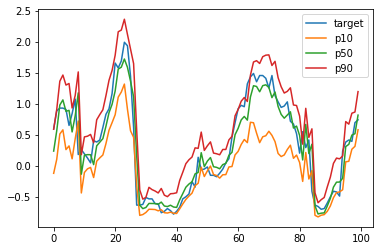

In [14]:
from matplotlib import pyplot as plt
plt.plot(output_map['targets']['t+0'][:100], label='target')
plt.plot(output_map['p10']['t+0'][:100], label='p10')
plt.plot(output_map['p50']['t+0'][:100], label='p50')
plt.plot(output_map['p90']['t+0'][:100], label='p90')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

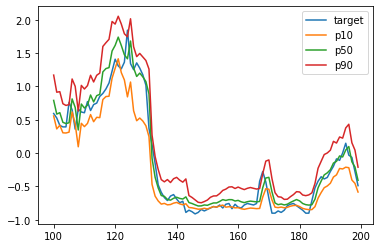

In [30]:
plt.plot(output_map['targets']['t+0'][100:200], label='target')
plt.plot(output_map['p10']['t+0'][100:200], label='p10')
plt.plot(output_map['p50']['t+0'][100:200], label='p50')
plt.plot(output_map['p90']['t+0'][100:200], label='p90')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

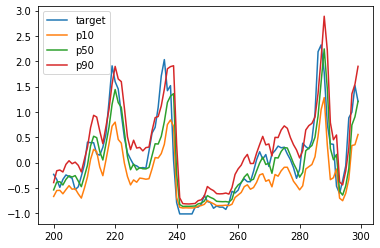

In [31]:
plt.plot(output_map['targets']['t+0'][200:300], label='target')
plt.plot(output_map['p10']['t+0'][200:300], label='p10')
plt.plot(output_map['p50']['t+0'][200:300], label='p50')
plt.plot(output_map['p90']['t+0'][200:300], label='p90')
plt.legend()
plt.show

In [23]:
# Store outputs in maps
counts = 0
interpretability_weights = {k: None for k in ['decoder_self_attn',
                                              'static_flags', 'historical_flags', 'future_flags']}

tf.compat.v1.get_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:
    
    tf.compat.v1.keras.backend.set_session(sess)
    
    # Create a new model & load weights
    model = TemporalFusionTransformer(model_params,
                                      use_cudnn=True)
    
    model.load(model_folder)
    for identifier, sliced in test.groupby('id'):
        
        print("Getting attention weights for {}".format(identifier))
        weights = model.get_attention(sliced)
        
        for k in interpretability_weights:
            w = weights[k]
            
            # Average attentin across heads if necessary
            if k == 'decoder_self_attn':
                w = w.mean(axis=0)
                
                # Store a single matrix for weights to reduce memory footprint
                batch_size, _, _ = w.shape
                counts += batch_size
            
            if interpretability_weights[k] is None:
                interpretability_weights[k] = w.sum(axis=0)
            else:
                interpretability_weights[k] += w.sum(axis=0)
                
interpretability_weight = {k: interpretability_weights[k]/counts for k in interpretability_weights}

print('Done.')

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.001
# minibatch_size = 128
# max_gradient_norm = 100.0
# num_heads = 1
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed
# total_time_steps = 36
# num_encoder_steps = 24
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('month', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_

In [24]:
import numpy as np
def get_range(static_gate, axis=None):
    """
    Returns the mean, 10th, 50th and 90th percentile of variable importance weights.
    """
    return {'Mean': static_gate.mean(axis=axis),
            '10%': np.quantile(static_gate, 0.1, axis=axis),
            '50%': np.quantile(static_gate, 0.5, axis=axis),
            '90%': np.quantile(static_gate, 0.9, axis=axis)}

In [25]:
def flatten(x):
    static_attn = x
    static_attn = static_attn.reshape([-1, static_attn.shape[-1]])
    return static_attn

static_attn = flatten(interpretability_weights['static_flags'])
m = get_range(static_attn, axis=0)
pd.DataFrame({k: pd.Series(m[k], index=['ID']) for k in m})

,Mean,10%,50%,90%
ID,8725.0,8725.0,8725.0,8725.0


In [26]:
x = flatten(interpretability_weights['historical_flags'])
m = get_range(x, axis=0)
pd.DataFrame({k: pd.Series(m[k]) for k in m})

,Mean,10%,50%,90%
0,419.243530,419.196210,419.221130,419.316217
1,415.238037,415.161215,415.217194,415.341113
2,776.587463,776.563562,776.579071,776.619501
3,576.570435,576.464148,576.555664,576.721094
4,385.851288,385.795132,385.832077,385.931476
5,398.844940,398.764209,398.830811,398.939398
6,2426.069580,2425.078662,2426.289551,2426.614038
7,57.421757,57.382811,57.419743,57.466259
8,191.367111,191.201646,191.401947,191.483786
9,428.493988,428.414777,428.481674,428.584747


In [ ]:
# Plotting libraries & Functions
import plotly.offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
import plotly.graph_objs as go
import cufflinks as cf
from IPython.display import HTML

# Loads plotly charts
def iplot(fig, s='plot.html'):
    filename = os.path.join(output_folder, s)
    plotly.offline.plot(fig, filename=filename, auto_open=False)
    return HTML(filename)

def plotly_chart(df, title=None, kind='scatter', x_label=None, y_label=None, secondary_y=None, fill=None,
                 shape=None, subplots=False):
    fig = df.iplot(asFigure=True, title=title, kind=kind, xTitle=x_label, yTitle=y_label, secondary_y=secondary_y,
                   fill=fill, subplots=subplots, shape=shape)
    
    return iplot(fig)



In [ ]:
self_attn = interpretability_weights['decoder_self_attn']
print(len(self_attn))
means = pd.DataFrame({"horizon={}".format(k): self_attn[model.num_encoder_steps+k-1, :]
                      for k in list(range(1, 52))})

means.index -= model.num_encoder_steps

plotly_chart(means,
             x_label="Positiion Index (n)",
             y_label="Mean Attention Weight",
             title="Average Attention Pattern at Various Prediction Horizons")

